In [24]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['c:\\Users\\anaxa\\Documents\\Projects\\BAMT', 'c:\\Users\\anaxa\\Documents\\Projects', 'c:\\Users\\anaxa\\Documents\\Projects\\BAMT']


In [2]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from bamt.Preprocessors import Preprocessor
from bamt.ScoringFunctions import BICGMM, BICGauss, BIC_local, BIC_local_gauss
from bamt.mi_entropy_gauss import mi_gauss
import bamt.Networks as Nets
from pgmpy.estimators import K2Score, BicScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
from bamt.utils.MathUtils import *
from gmr import GMM
from sklearn.metrics import mean_squared_error

In [3]:
def gmm_kl_sklearn (gmm_p, gmm_q, n = 10**5):
    X = gmm_p.sample(n)[0]
    log_p = gmm_p.score_samples(X)
    log_q = gmm_q.score_samples(X)
    return log_p.mean() - log_q.mean()

In [4]:
def gmm_js_sklearn(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

In [3]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 2):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal), 'AR': round(corr_undir/true_len, decimal), 'AHP': round(corr_dir/pred_len, decimal), 'AHR': round(corr_dir/true_len, decimal), 'SHD': shd}


In [49]:
data = pd.read_csv('../Data/daks_processed_with_rf_ntg.csv')
data

,Field name,Reservoir unit,Country,Region,Tectonic regime,Onshore/offshore,Hydrocarbon type,Productive area,Period,Depositional system,...,Permeability,Structural setting,Trapping mechanism,Depth,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor,NTG,NTG_calc
0,A.J.BERMUDEZ,UNNAMED (CUNDUACAN FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,NaN,CRETACEOUS,FORESLOPE,...,NaN,WRENCH,FOLD,3819.8,876.160991,0.33,NaN,NaN,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED (SAMARIA FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,24700.0,CRETACEOUS,FORESLOPE,...,NaN,WRENCH,FOLD,4120.1,876.160991,0.25,NaN,NaN,NaN,NaN
2,AB TEYMUR,ILAM,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,130910.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,NaN,FORELAND,FOLD,3063.1,904.153355,0.13,NaN,NaN,0.650,0.668255
3,AB TEYMUR,SARVAK-1,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,133380.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,NaN,FORELAND,FOLD,3263.1,909.967846,0.13,NaN,NaN,0.750,0.730104
4,ABKATUN,TAMABRA,MEXICO,LATIN AMERICA,COMPRESSION,OFFSHORE,OIL,58045.0,CRETACEOUS-PALEOGENE,FORESLOPE,...,3.1,SALT,FOLD,2920.7,887.147335,0.40,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,ПРИОБСКОЕ,Пласт: АС 10.0-1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,23.6,NaN,NaN,2487.0,880.800000,NaN,NaN,NaN,0.765,0.159504
1108,ПРИОБСКОЕ,Пласт: АС 10.1-3,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,32.7,NaN,NaN,2624.0,NaN,NaN,NaN,NaN,0.700,0.399123
1109,ПРИОБСКОЕ,Пласт: АС 10.4,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,33.4,NaN,NaN,2604.0,NaN,NaN,NaN,NaN,0.685,0.209756
1110,ПРИОБСКОЕ,Пласт: АС 12.1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,28.7,NaN,NaN,2628.0,875.450000,NaN,NaN,NaN,0.755,0.958904


In [50]:
cols = ['Gross','Netpay','Porosity','Permeability', 'Depth', 'NTG']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [51]:

discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(data)

2022-04-04 11:43:35,604 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [52]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_g = Nets.ContinuousBN(use_mixture=False)
bn_g.add_nodes(p.info)

bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(data, scoring_function=('K2', BICGMM))

  0%|          | 11/1000000 [03:29<5292:17:03, 19.05s/it]


In [53]:
bn_gmm.fit_parameters(data)

In [54]:
sample = bn_gmm.sample(500)

In [58]:
sample = sample[(sample > 0).all(1)]

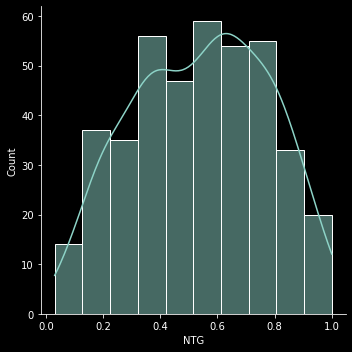

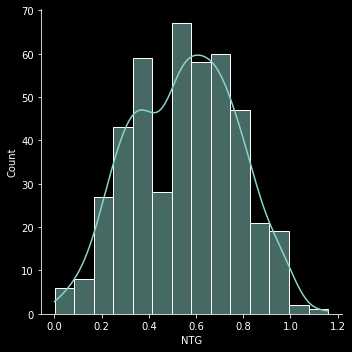

In [60]:
sns.displot(data['NTG'], kde=True)
sns.displot(sample['NTG'], kde=True)

In [61]:
bn_g.add_edges(data, scoring_function=('K2', BICGauss))
bn_g.fit_parameters(data)

  0%|          | 8/1000000 [00:36<1250:17:51,  4.50s/it]


In [62]:
sample = bn_g.sample(500)
sample = sample[(sample > 0).all(1)]

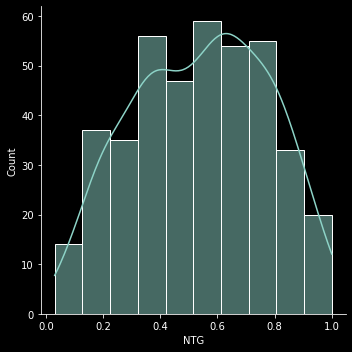

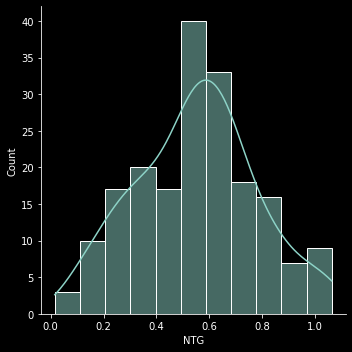

In [63]:
sns.displot(data['NTG'], kde=True)
sns.displot(sample['NTG'], kde=True)

In [8]:
with open('true_geo.txt') as f:
    lines = f.readlines()
true_net = []
for l in lines:
    e0 = l.split()[0]
    e1 = l.split()[1].split('\n')[0]
    true_net.append((e0, e1))

In [9]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.7, 'AR': 0.64, 'AHP': 0.3, 'AHR': 0.27, 'SHD': 11}

In [22]:
bn_gmm.fit_parameters(data)
bn_g.fit_parameters(data)

In [10]:
magic_niab = pd.read_csv('../Data/magic-niab.csv')
magic_niab

,Unnamed: 0,YR.GLASS,HT,YR.FIELD,MIL,FT,G418,G311,G1217,G800,...,G2318,G1294,G1800,YLD,FUS,G1750,G524,G775,G2835,G43
0,1,1.850018,77.765074,2.564389,2.420204,26.265806,1.653553,2.516479,2.449802,-0.093150,...,2.436271,1.813250,0.018578,7.652005,3.975359,0.772111,-0.214485,-0.188022,0.079201,-0.383058
1,2,2.839491,76.217522,2.095247,2.565285,30.208382,2.577151,3.236348,1.689816,0.070203,...,0.283773,-0.035413,-0.008392,7.527689,3.907876,0.906836,-0.434054,-0.063614,0.183865,-0.186146
2,3,3.022887,82.850683,3.063358,1.974833,30.555465,2.329531,2.210721,0.660790,0.413814,...,1.082400,1.345098,-0.256810,7.044279,4.044179,0.508228,1.454514,0.241251,0.280978,-0.009919
3,4,2.612010,75.153944,2.880662,2.056629,28.975195,1.006496,2.018133,2.091939,1.434951,...,-0.573873,0.778596,0.015790,7.910269,2.398779,0.039330,1.522505,-0.251140,0.196395,0.379672
4,5,1.837893,79.826414,2.408474,1.131238,32.961607,0.279591,1.403947,0.601819,0.351644,...,1.846705,0.326005,-0.197754,7.624186,2.025235,0.445918,-0.133272,0.000988,0.064264,-0.245253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2.690520,81.155640,2.674637,1.686609,29.902948,1.875717,1.029553,3.086662,1.315353,...,2.388208,-0.026363,0.326988,7.203066,4.405741,1.669258,0.385199,1.265128,0.034245,0.721200
9996,9997,1.923928,86.262416,2.324001,2.692981,33.723243,1.073841,2.338446,0.619690,-0.146723,...,0.365139,1.509082,-0.175006,7.573254,3.137440,1.196690,0.757912,1.336300,0.552159,-0.701045
9997,9998,2.603185,74.792966,1.678920,3.743690,30.259583,2.145234,0.887267,1.905390,0.623072,...,-0.359306,1.451596,0.215214,7.969182,4.452665,-0.014594,1.180278,-0.784018,0.226978,0.957887
9998,9999,2.522610,77.659865,2.322304,1.552042,36.221466,0.588949,2.024825,2.067248,0.281660,...,1.054323,1.109342,-0.033521,7.035835,3.143541,-0.231903,-0.437413,-0.611217,0.068308,-0.333437


In [11]:
magic_niab = magic_niab.drop(columns=['Unnamed: 0'])
magic_niab

,YR.GLASS,HT,YR.FIELD,MIL,FT,G418,G311,G1217,G800,G866,...,G2318,G1294,G1800,YLD,FUS,G1750,G524,G775,G2835,G43
0,1.850018,77.765074,2.564389,2.420204,26.265806,1.653553,2.516479,2.449802,-0.093150,-0.228616,...,2.436271,1.813250,0.018578,7.652005,3.975359,0.772111,-0.214485,-0.188022,0.079201,-0.383058
1,2.839491,76.217522,2.095247,2.565285,30.208382,2.577151,3.236348,1.689816,0.070203,0.835546,...,0.283773,-0.035413,-0.008392,7.527689,3.907876,0.906836,-0.434054,-0.063614,0.183865,-0.186146
2,3.022887,82.850683,3.063358,1.974833,30.555465,2.329531,2.210721,0.660790,0.413814,1.815822,...,1.082400,1.345098,-0.256810,7.044279,4.044179,0.508228,1.454514,0.241251,0.280978,-0.009919
3,2.612010,75.153944,2.880662,2.056629,28.975195,1.006496,2.018133,2.091939,1.434951,1.047136,...,-0.573873,0.778596,0.015790,7.910269,2.398779,0.039330,1.522505,-0.251140,0.196395,0.379672
4,1.837893,79.826414,2.408474,1.131238,32.961607,0.279591,1.403947,0.601819,0.351644,0.667261,...,1.846705,0.326005,-0.197754,7.624186,2.025235,0.445918,-0.133272,0.000988,0.064264,-0.245253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.690520,81.155640,2.674637,1.686609,29.902948,1.875717,1.029553,3.086662,1.315353,1.963228,...,2.388208,-0.026363,0.326988,7.203066,4.405741,1.669258,0.385199,1.265128,0.034245,0.721200
9996,1.923928,86.262416,2.324001,2.692981,33.723243,1.073841,2.338446,0.619690,-0.146723,1.458286,...,0.365139,1.509082,-0.175006,7.573254,3.137440,1.196690,0.757912,1.336300,0.552159,-0.701045
9997,2.603185,74.792966,1.678920,3.743690,30.259583,2.145234,0.887267,1.905390,0.623072,2.442949,...,-0.359306,1.451596,0.215214,7.969182,4.452665,-0.014594,1.180278,-0.784018,0.226978,0.957887
9998,2.522610,77.659865,2.322304,1.552042,36.221466,0.588949,2.024825,2.067248,0.281660,-1.491405,...,1.054323,1.109342,-0.033521,7.035835,3.143541,-0.231903,-0.437413,-0.611217,0.068308,-0.333437


In [12]:
magic_niab = magic_niab.sample(50)
magic_niab.reset_index(inplace=True, drop=True)


In [7]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
magic_niab_discrete, est = p.apply(magic_niab)

2022-03-29 17:22:09,788 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [18]:
hc_gmm_score_K2 = HillClimbSearch(magic_niab_discrete)
best_model_gmm_score_K2 = hc_gmm_score_K2.estimate(
                    scoring_method=K2Score(magic_niab_discrete))

  0%|          | 92/1000000 [00:34<103:36:14,  2.68it/s]


In [17]:
np.array_split(magic_niab, 3)

,YR.GLASS,HT,YR.FIELD,MIL,FT,G418,G311,G1217,G800,G866,...,G2318,G1294,G1800,YLD,FUS,G1750,G524,G775,G2835,G43
17,2.267905,69.945474,2.792538,1.847446,29.217850,-0.176746,1.991954,2.205261,1.215629,2.483028,...,1.391022,-0.471464,0.191594,7.978552,4.144838,0.529564,-0.968422,0.350054,-0.224210,-0.155204
18,3.059651,77.517135,1.749528,2.551198,26.109612,0.465272,2.187628,1.272835,0.273368,2.365361,...,1.701055,0.472771,0.164779,8.378077,2.900142,0.873867,0.705380,0.010825,0.328915,-0.564754
19,2.769062,86.617424,2.659721,2.151721,24.798850,2.117152,2.970770,0.716347,-0.555948,0.458635,...,1.623676,2.607688,0.035889,8.231848,4.101495,-0.097854,0.876360,-0.633647,0.038711,-0.572300
20,2.582459,77.983982,2.731232,1.484383,33.716589,1.658517,1.332512,0.838786,1.850688,1.242110,...,1.538233,2.830626,0.247908,6.990695,3.226821,0.217329,-0.105361,-0.069192,0.638555,0.373786
21,2.860454,80.145599,3.058951,2.358175,24.537164,1.017355,2.256278,1.635245,1.117330,1.229396,...,3.002929,0.239991,-0.021055,7.249460,2.297578,0.990548,-0.070269,-0.462744,0.058776,-0.527603
22,2.907263,77.008678,2.358285,2.873409,33.456534,1.497277,0.875993,3.405139,1.632258,2.344010,...,0.281013,-0.651639,0.619565,7.412525,4.276598,0.670577,0.604606,-0.733197,0.321440,1.264455
23,2.008948,78.789035,1.981578,2.388992,34.740938,0.621031,1.371686,1.366148,1.081489,3.824783,...,1.661235,-0.160264,0.277721,6.610018,3.739287,0.108160,1.633846,-0.040336,0.611760,0.290904
24,2.424867,80.690343,2.281782,1.526347,31.226469,1.195055,0.141039,2.957270,2.250666,2.159386,...,2.478479,0.218848,0.028004,7.354517,4.674353,-0.061350,1.267253,0.363675,0.061145,0.225802
25,2.459047,77.265887,2.731102,2.589494,32.251685,1.415420,1.177599,0.787353,0.299474,1.184027,...,1.192417,0.017161,0.024545,7.516852,3.905115,-0.105108,0.329611,0.395215,0.524831,0.922419
26,2.745866,80.819765,2.421327,1.603026,27.642221,2.215848,0.078126,0.749448,1.353921,0.327800,...,2.250472,2.084873,-0.012084,7.985983,3.364198,-0.492386,-0.837264,-0.686049,-0.054253,0.391821


In [14]:
hc_gmm_score = HillClimbSearch(magic_niab)
best_model_gmm_score = hc_gmm_score.estimate(
                    scoring_method=BICGMM(magic_niab))

  0%|          | 3/1000000 [18:05<100513:54:53, 361.85s/it] 


LinAlgError: 1-th leading minor of the array is not positive definite

In [20]:
with open('magic-niab-true.txt') as f:
    lines = f.readlines()
true_net = []
for l in lines:
    e0 = l.split()[0]
    e1 = l.split()[1].split('\n')[0]
    true_net.append((e0, e1))

In [21]:
precision_recall(list(best_model_gmm_score_K2.edges()), true_net)

{'AP': 0.11, 'AR': 0.07, 'AHP': 0.05, 'AHR': 0.04, 'SHD': 213}

In [22]:
precision_recall(list(best_model_gmm_score.edges()), true_net)

{'AP': 0.35, 'AR': 0.16, 'AHP': 0.19, 'AHR': 0.09, 'SHD': 165}

In [8]:
import random
K = 3
means = []
covs = []
w = []
N = 500
for _ in range(K):
    means.append([random.randint(0, 15)])
    covs.append(np.array([[random.randint(0, 5)]]))
    w.append(1/K)
gmm = GMM(n_components=K, priors=w, means=means, covariances=covs)
W = gmm.sample(N)


In [9]:
Nx = np.random.uniform(-1, 1, 500)
Nx = Nx.reshape(500,1)
X = W*W + Nx

In [10]:
Ny = np.random.uniform(-1, 1, 500)
Ny = Ny.reshape(500,1)
Y = 4*np.sqrt(np.abs(W)) + Ny

In [11]:
Nz = np.random.uniform(-1, 1, 500)
Nz = Nz.reshape(500,1)
Z = 2*np.sin(X) + 2*np.sin(Y) + Nz

In [12]:
synth_data = pd.DataFrame()
synth_data['W'] = W.reshape(500,)
synth_data['X'] = X.reshape(500,)
synth_data['Y'] = Y.reshape(500,)
synth_data['Z'] = Z.reshape(500,)

In [16]:
true_net = [('W', 'X'), ('W', 'Y'), ('X', 'Z'), ('Y', 'Z')]

In [14]:

discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(synth_data)


2022-03-30 18:02:41,017 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [25]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(synth_data, scoring_function=('K2', BICGMM))

  0%|          | 5/1000000 [00:51<2884:26:01, 10.38s/it]


In [27]:
bn_gmm.fit_parameters(synth_data)

In [28]:
sample = bn_gmm.sample(500)

<AxesSubplot:>

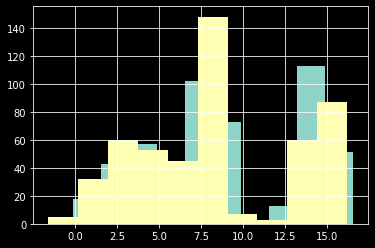

In [39]:
synth_data['Y'].hist()
sample['Y'].hist()

In [17]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 1.0, 'AR': 1.0, 'AHP': 1.0, 'AHR': 1.0, 'SHD': 0}

In [44]:
bn_gmm = Nets.ContinuousBN(use_mixture=False)
bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(discretized_data, scoring_function=('K2', K2Score))

  0%|          | 5/1000000 [00:01<65:10:27,  4.26it/s] 


In [45]:
bn_gmm.fit_parameters(synth_data)

In [46]:
sample = bn_gmm.sample(500)

<AxesSubplot:>

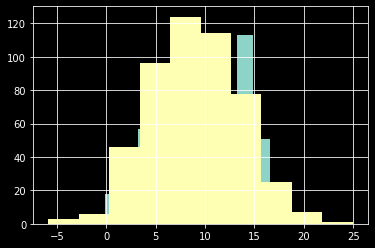

In [47]:
synth_data['Y'].hist()
sample['Y'].hist()

In [21]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.6, 'AR': 0.75, 'AHP': 0.6, 'AHR': 0.75, 'SHD': 3}

In [22]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(synth_data, scoring_function=('K2', BICGauss))

  0%|          | 4/1000000 [00:16<1123:07:38,  4.04s/it]


In [23]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.75, 'AR': 0.75, 'AHP': 0.5, 'AHR': 0.5, 'SHD': 3}